In [1]:
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy.wcs import WCS
from ClusterModel import model
from ClusterModel import model_modpar
from ClusterModel import model_tools

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
clust = model.Cluster(name='Coma', 
                      redshift=0.023, M500=7e14*u.Msun, 
                      cosmology=cosmo, silent=True, 
                      output_dir='/home/astrogamma/Project/Output/TestClusterModel')

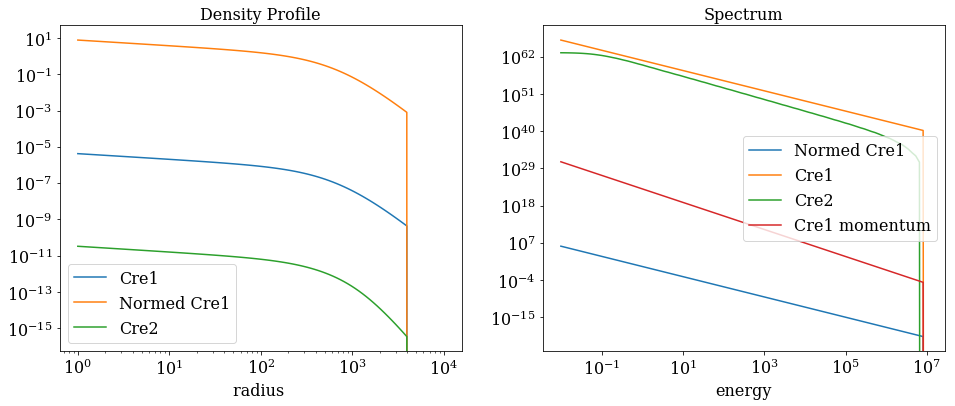

In [3]:
radius=np.logspace(0,4,100)*u.kpc
energy=np.logspace(-2,7,100)*u.GeV

# The simplest plots: density profile and spectrum
plt.figure(figsize=(15,6))
plt.subplot(121)

a,b = clust.get_density_cre1_profile(radius)
plt.loglog(a,b, label='Cre1')
a, b = clust.get_normed_density_cre1_profile(radius)
plt.loglog(a, b, label='Normed Cre1')
a,b = clust.get_density_cre2_profile(radius)
plt.loglog(a,b, label='Cre2')
plt.xlabel('radius ')
plt.title("Density Profile")
plt.legend()


plt.subplot(122)
a, b = clust.get_normed_cre1_spectrum(energy)
plt.loglog(a, b,label = 'Normed Cre1')
a, b = clust.get_cre1_spectrum(energy)
plt.loglog(a,b, label = 'Cre1')
a, b = clust.get_cre2_spectrum(energy)
plt.loglog(a,b, label = 'Cre2')
clust.spectrum_cre1_model["name"] = 'MomentumPowerLaw'
a, b = clust.get_cre1_spectrum(energy)
plt.loglog(a,b, label = 'Cre1 momentum')
plt.xlabel('energy')
plt.title("Spectrum")
plt.legend()

# Three Fits to Coma Data

In [ ]:

dat_freq = np.array([30.9,43,73.8,151,326,408,430,608.5,1380,1400,2675,2700,4850])*u.MHz
dat_flux = np.array([49,51,17,7.2,3.81,2.0,2.55,1.2,0.53,0.64,0.11,0.07,0.03])*u.Jy
dat_err  = np.array([10,13,12,0.8,0.03,0.2,0.28,0.3,0.05,0.035,0.03,0.02,0.01])*u.Jy

from scipy import optimize

dat_freq = dat_freq.to('GHz')

## Fit 1: Assume all emission from Secondary electrons
What is the Xcrp result?

In [ ]:
%%time


## ASSUMING ALL EMISSION COMES FROM CRP GENERATED SECONDARY ELECTRONS
def syncfitSecondary(x,a, ind):
    clust.X_crp_E = {'X':a, 'R_norm': clust.R500}
    clust.X_cre1_E = {'X':0, 'R_norm': clust.R500}
    clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':ind }
    return clust.get_synchrotron_spectrum(x*u.GHz)[1].to_value('Jy')

params2, params_covariance = optimize.curve_fit(syncfitSecondary, dat_freq.to_value('GHz'), dat_flux.to_value('Jy'), 
                                               sigma = dat_err.to_value('Jy'),
                                               p0=[0.01, 3])


print "Secondary electron parameters: "
print "X_crp = ",(params2[0])
print "index = ",(params2[1])


### The default value is 0.01, we find twice this

## Fit 2: Assume all emission from Primary Electrons

In [ ]:

def syncfitPrimary(x,a, ind):
    clust.X_crp_E = {'X':0.0, 'R_norm': clust.R500}
    clust.X_cre1_E = {'X':a, 'R_norm': clust.R500}
    clust.spectrum_cre1_model = {'name':'PowerLaw', 'Index':ind }
    return clust.get_synchrotron_spectrum(x*u.GHz)[1].to_value('Jy')


params1, params_covariance = optimize.curve_fit(syncfitPrimary, dat_freq.to_value('GHz'), dat_flux.to_value('Jy'), 
                                               sigma = dat_err.to_value('Jy'),
                                               p0=[0.01, 3])

print "Primary Electron Parameters: "
print "X_cre1 = ",(params1[0])
print "index = ",(params1[1])

### This is very high

## Fit 3: Fix Xcrp = 0.01, find additional primary electron contribution

In [ ]:

def syncfitPrimExtra(x,a, ind):
    clust.X_crp_E = {'X':0.01, 'R_norm': clust.R500}
    clust.X_cre1_E = {'X':a, 'R_norm': clust.R500}
    clust.spectrum_cre1_model = {'name':'PowerLaw', 'Index':ind }
    return clust.get_synchrotron_spectrum(x*u.GHz)[1].to_value('Jy')


params3, params_covariance = optimize.curve_fit(syncfitPrimExtra, dat_freq.to_value('GHz'), dat_flux.to_value('Jy'), 
                                               sigma = dat_err.to_value('Jy'),
                                               p0=[0.01, 3])

print "Primary Electron Parameters: "
print "X_cre1 = ",(params3[0])
print "index = ",(params3[1])

## Plot the primary electron population
X = 0.07

In [ ]:
clust.X_cre1_E['X'] = params3[0]

In [ ]:
radius=np.logspace(0,4,100)*u.kpc
energy=np.logspace(-2,7,100)*u.GeV

# The simplest plots: density profile and spectrum
plt.figure(figsize=(15,6))
plt.subplot(121)

a,b = clust.get_density_cre1_profile(radius)
plt.loglog(a,b, label='Cre1')
a, b = clust.get_normed_density_cre1_profile(radius)
plt.loglog(a, b, label='Normed Cre1')
a,b = clust.get_density_cre2_profile(radius)
plt.loglog(a,b, label='Cre2')
plt.xlabel('radius ')
plt.title("Density Profile")
plt.legend()


plt.subplot(122)
a, b = clust.get_normed_cre1_spectrum(energy)
#plt.loglog(a, b,label = 'Normed Cre1')
a, b = clust.get_cre1_spectrum(energy)
plt.loglog(a,b, label = 'Cre1')
a, b = clust.get_cre2_spectrum(energy)
plt.loglog(a,b, label = 'Cre2')
clust.spectrum_cre1_model["name"] = 'MomentumPowerLaw'
a, b = clust.get_cre1_spectrum(energy)
#plt.loglog(a,b, label = 'Cre1 momentum')
plt.xlabel('energy')
plt.title("Spectrum")
plt.legend()

# Ratio

In [ ]:
clust.X_cre1_E['X'] = params3[0]
clust.X_cre1_E

In [ ]:
eng = model_tools.sampling_array(clust._Eemin , clust._Eemax, NptPd=clust._Npt_per_decade_integ, unit=True)


## CRe Energy
eng, f_cre1_E = clust.get_cre1_spectrum(eng)
Ienergy_cre1 = model_tools.trapz_loglog(eng * f_cre1_E, eng)
## Thermal Energy
rad, ene = clust.get_thermal_energy_profile(clust.R500)
ene = ene.to('GeV')
## RATIO
X_cre2_EX = float(Ienergy_cre1/ene)
X_cre2_EX

## Gamma Ray Emission

In [ ]:
r1, p1 = clust.get_gamma_profile(radius=np.logspace(0,4,1000)*u.kpc, 
                                 Emin=500*u.GeV, Emax=1*u.PeV, Energy_density=False)
r2, p2 = clust.get_gamma_profile(radius=np.logspace(0,4,1000)*u.kpc, 
                                 Emin=1000*u.GeV, Emax=10*u.PeV, Energy_density=False)

plt.figure(0,figsize=(15,10))
plt.loglog((r1/clust.D_ang*u.rad).to('deg'),p1.to('cm-2 s-1 sr-1'), '-')
plt.loglog((r2/clust.D_ang*u.rad).to('deg'),p2.to('cm-2 s-1 sr-1'), '--')


In [ ]:
eng    = np.logspace(-3, 6, 100)*u.GeV
eng1, dN_dEdSdt1 = clust.get_gamma_spectrum(eng, Rmax=1000*u.kpc, type_integral='spherical')
#eng2, dN_dEdSdt2 = clust.get_gamma_spectrum(eng, Rmax=1000*u.kpc, type_integral='cylindrical')

plt.figure(1,figsize=(15,10))
plt.loglog(eng1, dN_dEdSdt1, '')
#plt.loglog(eng2, dN_dEdSdt2, '--')